# 데이터 기반의 콘텐츠 추천 서비스 구현 A
-- [ 전용준. YONG. Yong Xune Xon. 리비젼컨설팅. revisionconsulting. revision.co.kr. xyxonxyxon@empal.com ]
- Updated Version as of 20200320.

Association Rule Generation using Apriori

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.style as style 
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# define path for the dataset to use
dataPath = 'https://github.com/stillxyxon/kma_RecSys2020/raw/master/'


### Section 1. Load dataset
<br>

- A publicly availble dataset of B2B online retailer
- Data source : https://archive.ics.uci.edu/ml/datasets/online+retail
- Most of the customers are wholesalers in Europe

In [171]:
# Import Dataset 
# dataset = pd.read_csv(‘apriori_data2.csv’, header = None)

tr01a = pd.read_csv(dataPath + 'onlineRetail_A.csv',
                   dtype = {"StockCode" : "str"})

tr01b = pd.read_csv(dataPath + 'onlineRetail_B.csv', 
                    dtype = {"StockCode" : "str"})

print('tr01a and tr01b loaded')
# to bypass github upload size limitation, read pre-split datasets and merge back again
tr01c = pd.concat([tr01a, tr01b], axis=0)
print(tr01c.shape)

# select basket and item IDs
tr01 = tr01c[['CustomerID','StockCode']]
print(tr01.shape)
tr01c.head()

tr01a and tr01b loaded
(541909, 8)
(541909, 2)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


### Basic EDA on the dataset

In [172]:
print('Unique Customers :', len(tr01c.CustomerID.unique()))
print('Unique Invoices :', len(tr01c.InvoiceNo.unique()))
print('Unique StockCodes :', len(tr01c.StockCode.unique()))

Unique Customers : 4373
Unique Invoices : 25900
Unique StockCodes : 4070


In [177]:
# print(tr01.shape)

tr01 = tr01c[['CustomerID','StockCode']]
# 값이 없는 레코드의 수 확인 -- 분석 제외 대상
print('count NAs \n', tr01.isnull().sum())

# exclude records with no customerID
tr01 = tr01.dropna().drop_duplicates()
print(tr01.shape)

tr01['CustomerID'] = tr01.CustomerID.astype(int).astype(str)

count NAs 
 CustomerID    135080
StockCode          0
dtype: int64
(267615, 2)


4372


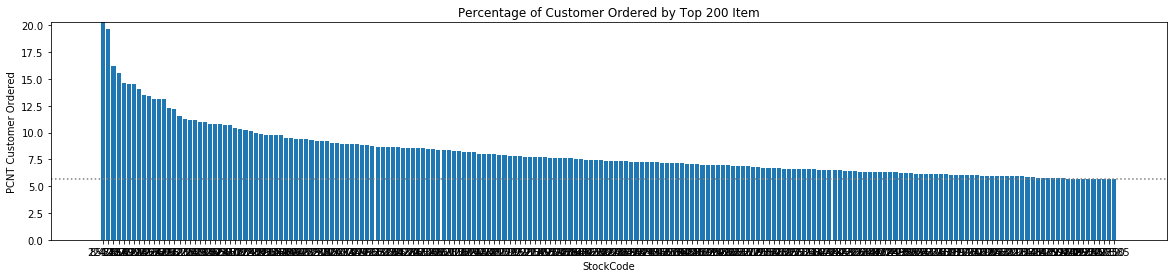

3684


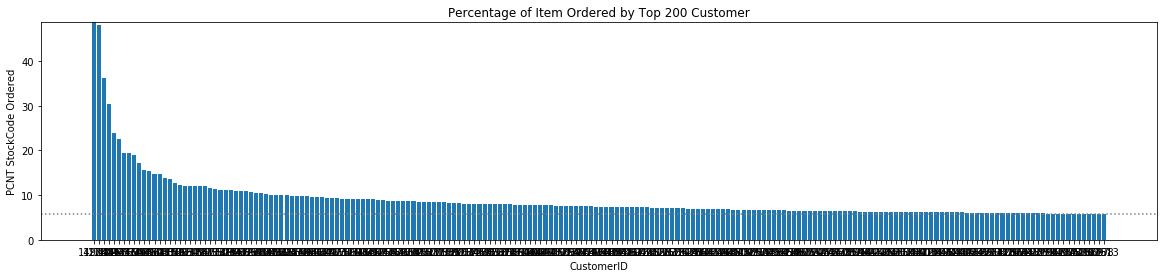

In [65]:
# Check Frequency Distribution

nCust = len(tr01.CustomerID.unique())
print(nCust)
plt.figure(figsize = (20,4))
plt.bar(tr01.StockCode.value_counts()[:200].index,
        tr01.StockCode.value_counts()[:200]*100/nCust)
plt.ylim(0,tr01.StockCode.value_counts()[:200].max()*100/nCust)
plt.axhline(tr01.StockCode.value_counts()[:200].min()*100/nCust, 
            linestyle=':', color='grey')
plt.ylabel('PCNT Customer Ordered')
plt.xlabel('StockCode')
plt.title('Percentage of Customer Ordered by Top 200 Item')
plt.show()


# Check Frequency Distribution

nStockCode = len(tr01.StockCode.unique())
print(nStockCode)
plt.figure(figsize = (20,4))
WideCusts = tr01.CustomerID.value_counts()[:200]
plt.bar(WideCusts.index,
        WideCusts*100/nStockCode)
plt.ylim(0,WideCusts.max()*100/nStockCode)
plt.axhline(WideCusts.min()*100/nStockCode, 
            linestyle=':', color='grey')
plt.ylabel('PCNT StockCode Ordered')
plt.xlabel('CustomerID')
plt.title('Percentage of Item Ordered by Top 200 Customer')
plt.show()

## Section 2. Extracting association rules 

In [70]:
# Association rule generation을 위해 list format (i.e. wide format)으로 변환

tmparr = []
ucusts = tr01.CustomerID.unique()
numcusts = len(ucusts)

for i in range(0, numcusts-1):
    tmpdf = tr01.loc[tr01['CustomerID']==ucusts[i]]
    tmparr.append(list(tmpdf['StockCode']))

# Check the formatted
print(np.array(tmparr).shape)
np.array(tmparr[:3])

(4371,)


array([list(['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730', '22633', '22632', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '15056BL', '22803', '22411', '21874', '71477', '21169']),
       list(['84879', '22745', '22748', '22749', '22310', '84969', '22623', '22622', '21754', '21755', '21777', '48187', '22960', '22913', '22912', '22914', '21756', '22274', '16161P', '22766', '22708', '23231', '85015', '85016', '22829', '22722', '22961', '22969', '22720', '22549', '20972', '22743', '21658', '48184', '22692', '22499', '22607', '47566', '21902', '21901', '21899', '21900', '22077', '85123A', '23152', '23182', '23161', '23160', '23163', '23162', '23164', '23177', '23176', '23006', '22996', '23070', '23126', '23299', '22423', '21621', '23092', '23112', '23110', '23111', '23118', '23093', '23089', '23168', '23236', '23240', '23175', '23173', '23245', '23032', '23031', '23029', '23028', '85053', '22090', '22089', '22088', '23546', '23545', 

In [179]:
# Train Apriori Model

from apyori import apriori

rules = apriori(tmparr, min_support = 0.03, min_confidence = 0.3, min_lift = 3, max_length = 2)

# try min_support = 0.02 or min_confidence = 0.2 or min_support = 0.05 or min_confidence = 0.33 alternatively

# to check the distribution of rules ( CAUTION :: takes a while )
# rules = apriori(tmparr, min_support = 0.01, min_confidence = 0.1, min_lift = 2, max_length = 2)



# Listing the resulting Rules
results = list(rules)
print(results[:5])

print("\nnumber of rules : " + str(len(results)) + '\n')
num_rules = len(results)



[RelationRecord(items=frozenset({'20685', '85099B'}), support=0.033401967513154884, ordered_statistics=[OrderedStatistic(items_base=frozenset({'20685'}), items_add=frozenset({'85099B'}), confidence=0.44376899696048633, lift=3.0498652291105124)]), RelationRecord(items=frozenset({'20712', '20726'}), support=0.03065660032029284, ordered_statistics=[OrderedStatistic(items_base=frozenset({'20712'}), items_add=frozenset({'20726'}), confidence=0.5403225806451614, lift=6.33176943699732), OrderedStatistic(items_base=frozenset({'20726'}), items_add=frozenset({'20712'}), confidence=0.35924932975871315, lift=6.33176943699732)]), RelationRecord(items=frozenset({'20712', '22386'}), support=0.030427819720887667, ordered_statistics=[OrderedStatistic(items_base=frozenset({'20712'}), items_add=frozenset({'22386'}), confidence=0.5362903225806451, lift=6.30141129032258), OrderedStatistic(items_base=frozenset({'22386'}), items_add=frozenset({'20712'}), confidence=0.3575268817204301, lift=6.301411290322581)

In [180]:
column_names = ["hypo", "conc", "conf","supp","lift"]
ruledf = pd.DataFrame(columns = column_names)

# Print rules one by one
for i in range(0, num_rules):
    result = results[i]
    # print(result)
    supp = int(result.support*10000)/100
    conf = int(result.ordered_statistics[0].confidence *1000)/10
    lift = int(result.ordered_statistics[0].lift *100)/100,
    hypo = ''.join([x+' ' for x in result.ordered_statistics[0].items_base]).strip()
    conc = ''.join([x+' ' for x in result.ordered_statistics[0].items_add]).strip()
    
    # print only 30 rules
    if i<30:
        print("{ "+str(hypo)+ " ==>  " + str(conc)  +
              " } [ conf = " + str(conf) + "%,"+ " supp = "+str(supp)+"%, " +
              " lift = "+str(list(lift)[0])+"]")

    # insert raws into a container df
    ruledf.loc[i] = [hypo, conc, conf, supp, list(lift)[0]]

{ 20685 ==>  85099B } [ conf = 44.3%, supp = 3.34%,  lift = 3.04]
{ 20712 ==>  20726 } [ conf = 54.0%, supp = 3.06%,  lift = 6.33]
{ 20712 ==>  22386 } [ conf = 53.6%, supp = 3.04%,  lift = 6.3]
{ 20712 ==>  23203 } [ conf = 53.6%, supp = 3.04%,  lift = 4.64]
{ 20712 ==>  85099B } [ conf = 69.3%, supp = 3.93%,  lift = 4.76]
{ 20713 ==>  85099B } [ conf = 73.4%, supp = 3.47%,  lift = 5.04]
{ 20719 ==>  20723 } [ conf = 55.4%, supp = 3.01%,  lift = 10.44]
{ 20719 ==>  20724 } [ conf = 68.4%, supp = 3.72%,  lift = 8.93]
{ 20719 ==>  22355 } [ conf = 55.8%, supp = 3.04%,  lift = 9.8]
{ 20723 ==>  20724 } [ conf = 71.5%, supp = 3.79%,  lift = 9.33]
{ 20723 ==>  20725 } [ conf = 57.3%, supp = 3.04%,  lift = 4.71]
{ 20723 ==>  22355 } [ conf = 59.9%, supp = 3.18%,  lift = 10.51]
{ 20724 ==>  20725 } [ conf = 50.4%, supp = 3.86%,  lift = 4.14]
{ 20724 ==>  20727 } [ conf = 40.2%, supp = 3.08%,  lift = 3.84]
{ 20724 ==>  20728 } [ conf = 40.8%, supp = 3.13%,  lift = 3.71]
{ 20724 ==>  22355 } [

In [181]:
ruledf.tail()

,hypo,conc,conf,supp,lift
549,84997B,84997D,70.6,3.24,12.45
550,84997C,84997D,85.0,3.91,14.99
551,85099B,85099C,35.3,5.14,5.05
552,85099B,85099F,38.9,5.67,5.37
553,85099C,85099F,49.6,3.47,6.84


### visual profiling of the resulting rule set

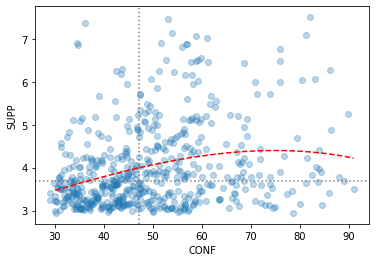

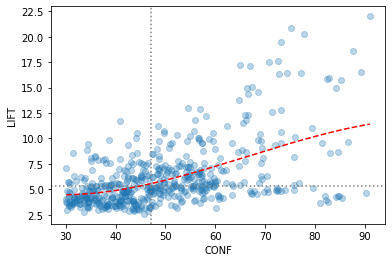

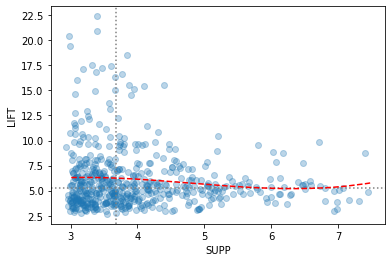

In [182]:
# profiling the resulting rule set

def scattrules(X, Y, Xlab, Ylab):
    plt.scatter(rjitt(X), rjitt(Y), alpha=0.3)
    plt.xlabel(Xlab)
    plt.ylabel(Ylab)
    plt.axvline(X.median(), linestyle=':', color='grey')
    plt.axhline(Y.median(), linestyle=':', color='grey')
    # add polynomial curve
    plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 3))(np.unique(X)), 
             color='red', linestyle='--')
    plt.show()

X = ruledf.conf
Y = ruledf.supp
Xlab, Ylab = 'CONF', 'SUPP'

scattrules(X, Y, Xlab, Ylab)    

scattrules(ruledf.conf, ruledf.lift, 'CONF', 'LIFT')    
scattrules(ruledf.supp, ruledf.lift, 'SUPP', 'LIFT')    


In [183]:
# attach description of stockCode for human inspection

dfItemName = tr01a[['StockCode','Description']].drop_duplicates().dropna()
dfItemName['StockCode'] = np.array(dfItemName.StockCode.astype(str))
dfItemName['Description'] = np.array(dfItemName.Description.astype(str))
dfItemName.shape

dfItemName.columns = ['hypo','deschypo']
dfItemName1 = dfItemName.copy()
dfItemName1.columns = ['conc','descconc']

dfItemName1 = dfItemName1[dfItemName1.descconc!='?']

dfItemName.head()
# to check if description is correct
dfItemName1[dfItemName1.conc=='85123A']

,conc,descconc
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER


In [184]:
# attach descriptions using left join

ruledf1 = pd.merge(ruledf, dfItemName, how='left', on='hypo')
ruledf1.head()
ruledf1.tail(10)

ruledf2 = pd.merge(ruledf1, dfItemName1, how='left', on='conc')
ruledf2.head()
ruledf3 = ruledf2[ (ruledf2.conf>30) & (ruledf2.lift>5)].sort_values('lift', ascending=False)
print('number of rules : ', len(ruledf3))
ruledf3

number of rules :  413


,hypo,conc,conf,supp,lift,deschypo,descconc
159,21086,21094,91.0,3.47,22.22,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES
589,23171,23172,76.4,3.40,20.87,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE PINK
206,21668,21669,77.6,3.01,20.32,RED STRIPE CERAMIC DRAWER KNOB,BLUE STRIPE CERAMIC DRAWER KNOB
578,22962,22963,73.4,3.04,19.46,JAM JAR WITH PINK LID,JAM JAR WITH GREEN LID
579,22962,22963,73.4,3.04,19.46,JAM JAR WITH PINK LID,JAM JAR WITH BLUE LID
...,...,...,...,...,...,...,...
559,22835,23355,54.5,3.95,5.03,HOT WATER BOTTLE I AM SO POORLY,NaN
659,23202,85099C,35.2,3.04,5.03,JUMBO BAG VINTAGE LEAF,JUMBO BAG BAROQUE BLACK WHITE
104,20726,23209,53.8,4.59,5.02,LUNCH BAG WOODLAND,mailout
105,20726,23209,53.8,4.59,5.02,LUNCH BAG WOODLAND,LUNCH BAG DOILEY PATTERN


- items with descriptions like cracked, faulty, damages are not useful for recommendation
- elimination required

In [185]:
ruledf3 = ruledf3[~(ruledf3.descconc.isin(['cracked', 'faulty', 'damages', 'mouldy, thrown away.', 'mailout']))]
print('number of rules : ', len(ruledf3))
ruledf3

number of rules :  388


,hypo,conc,conf,supp,lift,deschypo,descconc
159,21086,21094,91.0,3.47,22.22,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES
589,23171,23172,76.4,3.40,20.87,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE PINK
206,21668,21669,77.6,3.01,20.32,RED STRIPE CERAMIC DRAWER KNOB,BLUE STRIPE CERAMIC DRAWER KNOB
578,22962,22963,73.4,3.04,19.46,JAM JAR WITH PINK LID,JAM JAR WITH GREEN LID
579,22962,22963,73.4,3.04,19.46,JAM JAR WITH PINK LID,JAM JAR WITH BLUE LID
...,...,...,...,...,...,...,...
658,23202,85099C,35.2,3.04,5.03,mailout,JUMBO BAG BAROQUE BLACK WHITE
559,22835,23355,54.5,3.95,5.03,HOT WATER BOTTLE I AM SO POORLY,NaN
659,23202,85099C,35.2,3.04,5.03,JUMBO BAG VINTAGE LEAF,JUMBO BAG BAROQUE BLACK WHITE
105,20726,23209,53.8,4.59,5.02,LUNCH BAG WOODLAND,LUNCH BAG DOILEY PATTERN


- 추천이될 item (i.e. descconc) 의 가격이 너무 낮거나, 거래건 평균 금액합계(subtotal)이 작거나 한 경우 filter out (i.e. custom buiness rules) 적용 가능

## Section 3. Drawing Network Diagram using the Extracted Association Rules

red      20
grey     16
green     3
dtype: int64


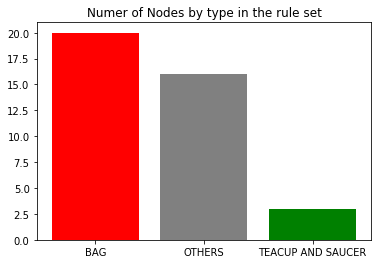

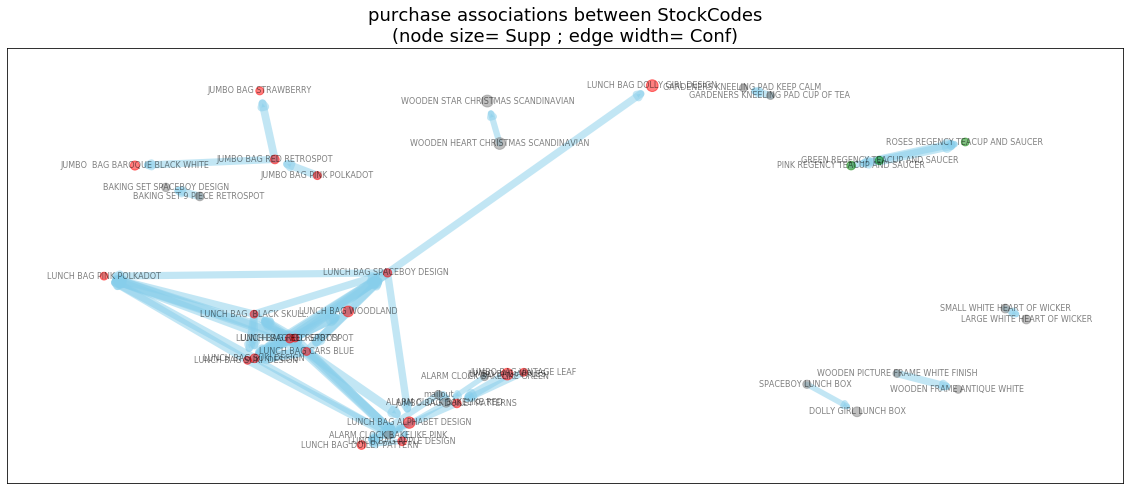

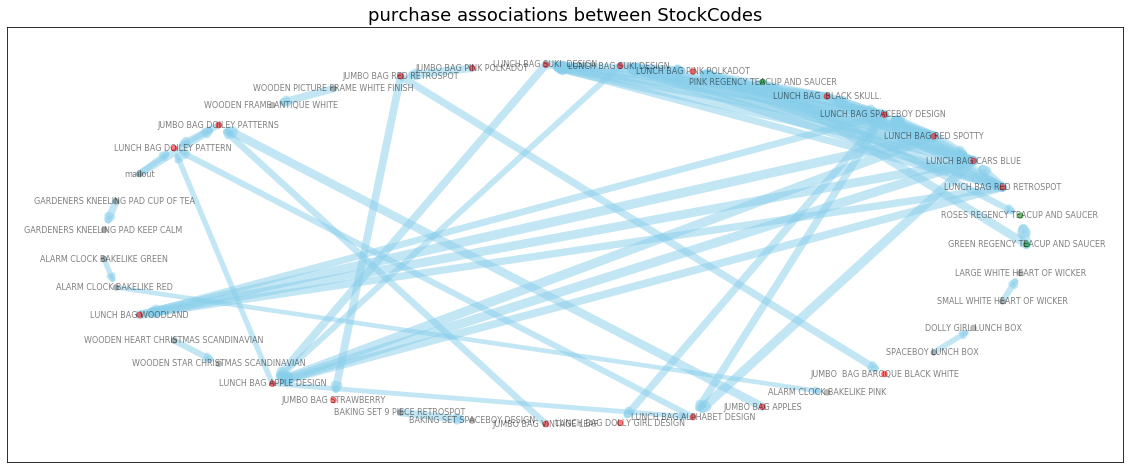

In [187]:
from matplotlib import pylab
from pylab import *
import networkx as nx

ruledf4 = ruledf3.sort_values('supp', ascending=False).head(60)
graph = nx.from_pandas_edgelist(ruledf4, source = 'deschypo', target = 'descconc', 
                                  edge_attr = 'conf', create_using = nx.DiGraph())

# set colors by item category
gnodes = np.array(graph.nodes)
gnode_types = ['red' if 'BAG' in x else x for x in gnodes]
gnode_types = ['green' if 'TEACUP AND SAUCER' in x else x for x in gnode_types]
gnode_types = [x if (x=='red') or (x=='green')  else 'grey' for x in gnode_types]


cntbyitemtype = pd.Series(gnode_types).value_counts()
print(cntbyitemtype )

plt.figure(figsize = (6,4))
plt.bar(['BAG','OTHERS','TEACUP AND SAUCER'], cntbyitemtype,
       color=['red','grey','green'])
plt.title('Numer of Nodes by type in the rule set')
plt.show()

plt.figure(figsize = (20,8))
pylab.title('purchase associations between StockCodes\n(node size= Supp ; edge width= Conf)', size=18)
nx.draw_networkx(graph, node_color=gnode_types, edge_color='skyblue',
                 font_size=8, alpha=0.5, 
                 node_size=np.array(ruledf.supp)*20,
                 width = np.array(ruledf3.conf*10/ruledf3.conf.max()),
                 arrow=True, 
                 pos=nx.spring_layout(graph) )
                
plt.show()


plt.figure(figsize = (20,8))
pylab.title('purchase associations between StockCodes', size=18)      
nx.draw_networkx(graph, node_color=gnode_types, edge_color='skyblue',
                 font_size=8, alpha=0.5, node_size=30, 
                 width = np.array(ruledf3.conf*10/ruledf3.conf.max()),
                 arrow=True, 
                 pos=nx.circular_layout(graph)
                )

# https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/ 

# plt.savefig("C:/YONG/m1710/0_AI_20171102/mov/fig_arm_001.png", format = "png", dpi = 400)
plt.show()

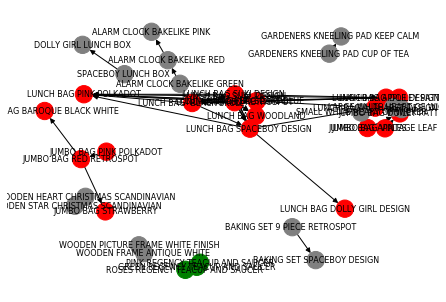

In [193]:
# node coloring example    

nx.draw(graph, node_color=gnode_types, with_labels=True,
       font_size=8)
plt.show()

## Section 4. Recommendation using the Rules

In [196]:
# select a sample customer to recommend

cust2rcmm = tr01.CustomerID.unique()[int(len(tr01.CustomerID.unique())/2.9)]
print('CustomerID : ', cust2rcmm)

boughts = tr01[tr01.CustomerID==cust2rcmm].StockCode.value_counts()
print('\nbought items : \n', boughts.index)

# subset of rules to be used
ruledf3[(ruledf3.hypo.isin(boughts.index)) & ~(ruledf3.conc.isin(boughts.index))].drop_duplicates().sort_values('lift', ascending=False).head()

CustomerID :  16425

bought items : 
 Index(['48111', '22624', '21656', '71510', '21624', '21497', '48194', '22207',
       '48129', '79403', '16161P', '22702', '84832', '23230', '48138', '22626',
       '48185', '21524', '21975', '21407', '21212'],
      dtype='object')


,hypo,conc,conf,supp,lift,deschypo,descconc
475,22624,22627,36.1,3.11,8.14,IVORY KITCHEN SCALES,MINT KITCHEN SCALES
265,21975,22417,49.1,3.24,7.95,PACK OF 60 DINOSAUR CAKE CASES,PACK OF 60 SPACEBOY CAKE CASES
474,22624,22625,52.1,4.48,7.77,IVORY KITCHEN SCALES,RED KITCHEN SCALES
267,21975,84992,50.8,3.36,6.84,PACK OF 60 DINOSAUR CAKE CASES,72 SWEETHEART FAIRY CAKE CASES
266,21975,84991,57.0,3.77,6.01,PACK OF 60 DINOSAUR CAKE CASES,60 TEATIME FAIRY CAKE CASES


## Appendix. Variations for Practice

- InvoiceNo instead of CustomerID (i.e. InvoiceNo as the basket)
- Trx date by CustomerID instead of CustomerID (i.e. Trx day as the basket)
- Eliminate too frequent rules
- Association Rule Set for each Country?